In [1]:
from copy import deepcopy # to deep copy data
import pandas as pd # to work with tabular data
import numpy as np # to generate random numbers and perform computations on numbers
import statsmodels.formula.api as smf # to fit mixed (i.e., fixed and random) effects models
import seaborn as sns # plot data

In [2]:
# ignoring warnings for this lesson to narrow focus on concepts
import warnings
warnings.filterwarnings('ignore')

In [4]:
MONTHS = 12
BASELINE_AGE = 10 * MONTHS # 10 years old

def generate_data(groups, timepoints, rng):
    """
    Parameters
    ----------
    groups : dict of dicts
        dictionary providing specific attributes of the data.
        The top level dictionary defines the groups, and the
        sub-dictionaries describe how to simulate the data:
        - mean: average simulated volume
        - variance: variance of the simulated volume
        - baseline_age: age to use as reference to interpret the intercept
        - n: number of participants
        - year_growth: yearly growth of volume
        - growth_wthn_variance: variance of the volume growth within an individual
        - growth_btwn_variance: variance of the volume grown between individuals
    timepoints : int
        number of timepoints to simulate
    rng : np.random.Generator
        random number generator to ensure reproducibility
    
    Returns
    -------
    df : pandas.DataFrame
        A long form DataFrame with the simulated data.
    """
    dfs = []
    for name, group in groups.items():
        # generate the volumes at baseline (different participants may have different baselines/intercepts)
        baseline_means = rng.normal(group['mean'], np.sqrt(group['variance']), group['n'])
        # determine the growth trajectory for each participant
        growth = rng.normal(group['year_growth'], np.sqrt(group['growth_btwn_variance']), group['n'])
        # add the growth trajectory to the baseline volume (different participants may have different trajectories/slopes)
        baseline_growth = np.linspace(baseline_means, baseline_means + (growth * (timepoints - 1)), timepoints)
        # add the within subject variance (participants may not follow their trajectory perfectly)
        wthn_subj_growth_variance = rng.normal(0, np.sqrt(group['growth_wthn_variance']), (timepoints, group['n']))
        # add the between and within subject variances together
        group_data = baseline_growth + wthn_subj_growth_variance
        
        # create column names for the dataframe
        columns = np.linspace(BASELINE_AGE, BASELINE_AGE + (MONTHS * (timepoints - 1)), timepoints)
        column_names = [f'volume-{int(age)}' for age in columns]
        
        # create a temporary dataframe
        tmp_df = pd.DataFrame(group_data.T, columns=column_names)
        tmp_df['group'] = [name] * tmp_df.shape[0]
        dfs.append(tmp_df)
    # combine all the groups into a single dataframe
    full_df = pd.concat(dfs, ignore_index=True)
    
    # transform the dataframe to long (from wide) format for analysis
    long_df = pd.wide_to_long(full_df.reset_index(), stubnames='volume', i='index', j='interview_age', sep='-')
    long_df = long_df.reset_index().rename(columns={'index': 'subjectkey'}).sort_values(by=['subjectkey', 'interview_age'], ignore_index=True)
    
    # demean the interview age (for a homework question)
    long_df['interview_age_demeaned'] = long_df['interview_age'] - group['baseline_age']
    return long_df
    

def plot_sample_data(df, n_participants=4):
    """
    Plots data for a subset of participants
    """
    sns.lmplot(
        x="interview_age",
        y="volume",
        col="subjectkey",
        hue="subjectkey",
        data=df[df['subjectkey'].isin(range(n_participants))],
        col_wrap=2,
        ci=None,
        palette="muted"
    )    
    

def analyze_data(df):
    """
    Runs:
    - a linear model
    - linear mixed model with random intercepts for participants
    - linear mixed model with random intercepts and slopes for participants
    """
    
    lm = smf.ols("volume ~ interview_age", df)
    lmf = lm.fit()
    print("Simple Linear Model (volume ~ interview_age)")
    print(lmf.summary())
    print("\n\n")
    
    mi = smf.mixedlm("volume ~ interview_age", df, groups="subjectkey")
    try:
        mif = mi.fit(method=["lbfgs"])
    except:
        print("Could Not Fit Mixed Effects Intercepts Model\n\n")
    else:
        print("Mixed Effects Model with intercept for 'subjectkey' (volume ~ interview_age + (1 | subjectkey))")
        print(mif.summary())
        print("\n\n")
    
    
    mis = smf.mixedlm("volume ~ interview_age", df, groups="subjectkey", re_formula="~interview_age")
    try:
        misf = mis.fit(method=["lbfgs"])
    except:
        print("Could Not Fit Mixed Effects Intercepts and Growth Model\n\n")
    else:
        print(("Mixed Effects Model with intercept for 'subjectkey' and slope for 'interview_age'" 
               "(volume ~ interview_age + (1 + interview_age | subjectkey))"))
        print(misf.summary())
        print("\n\n")
    

In [5]:
# want 3 timepoints
timepoints = 3

In [6]:
simple_group = {
    'control': {
        'mean': 7000,
        'variance': 0,
        'baseline_age': 120,
        'n': 200,
        'year_growth': 6,
        'growth_wthn_variance': 0,
        'growth_btwn_variance': 0,
    }
}
rng = np.random.default_rng(seed=123)
simple_df = generate_data(simple_group, timepoints, rng)

In [7]:
simple_df.head(n=9) # all participants look the same

,subjectkey,interview_age,group,volume,interview_age_demeaned
0,0,120,control,7000.0,0
1,0,132,control,7006.0,12
2,0,144,control,7012.0,24
3,1,120,control,7000.0,0
4,1,132,control,7006.0,12
5,1,144,control,7012.0,24
6,2,120,control,7000.0,0
7,2,132,control,7006.0,12
8,2,144,control,7012.0,24


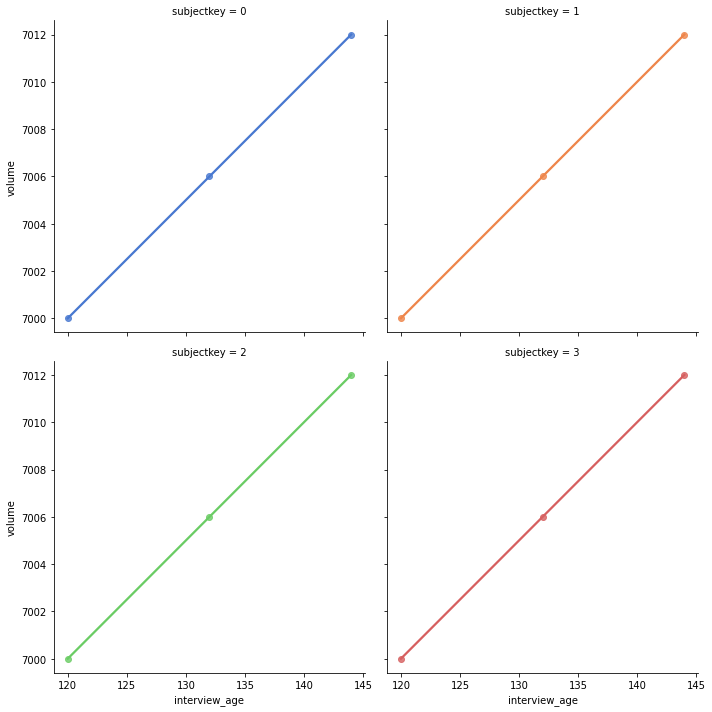

In [8]:
plot_sample_data(simple_df) # all participants look the same

In [9]:
analyze_data(simple_df)

Simple Linear Model (volume ~ interview_age)
                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.157e+27
Date:                Sat, 02 Apr 2022   Prob (F-statistic):               0.00
Time:                        16:35:53   Log-Likelihood:                 14972.
No. Observations:                 600   AIC:                        -2.994e+04
Df Residuals:                     598   BIC:                        -2.993e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
I

In [10]:
import matplotlib.gridspec as gridspec  # For customizing plot layout
import matplotlib.pyplot as plt  # For making plots to visualize our results
import numpy as np  # For working with array data
import pandas as pd  # For organizing results into dataframes
import seaborn as sns  # For plotting
import time  # For rudimentary executing timing

from scipy.constants import golden_ratio  # For scaling the aspect ratio of our figures

from sklearn.datasets import make_classification  # For generating a synthetic classification problem
from sklearn.impute import KNNImputer  # For imputing missing values in our synthetic dataset
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate  # For splitting our data
from sklearn.model_selection import LeaveOneGroupOut, RepeatedKFold, StratifiedKFold  # For splitting our data
from sklearn.svm import SVC  # Support vector machine classifier
from sklearn.metrics import accuracy_score  # To calculate...wait for it...the accuracy score
from sklearn.ensemble import AdaBoostRegressor  # For exploring the concept of ensembling
from sklearn.tree import DecisionTreeRegressor  # For exploring the concept of ensembling

from nilearn import datasets  # For exploring the Haxby dataset mentioned in the lecture
from nilearn.image import get_data  # See above comment
from nilearn.image import index_img  # See above comment
from nilearn.decoding import Decoder  # I could do this all day

In [11]:
RANDOM_STATE=901

In [12]:
# define dataset
X, y = make_classification(
    n_samples=1000,
    n_features=100,
    n_informative=20,
    n_redundant=0,
    n_repeated=0,
    random_state=RANDOM_STATE,
    flip_y=0.2,
)

# Choose random indexes to put NaN values into the data
n_nans = int(X.size * 0.02)
rng = np.random.default_rng(seed=RANDOM_STATE)
index_nan = rng.choice(X.size, n_nans, replace=False)
  
# Add the NaN values to the feature matrix.
X.ravel()[index_nan] = np.nan 

# Impute the missing values
imputer = KNNImputer()
X = imputer.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y
)

# Fit the model
model = SVC()
model.fit(X_train, y_train)

# evaluate the model
y_pred = model.predict(X_test)
# evaluate predictions
accuracy_1 = accuracy_score(y_test, y_pred)
print(f"With imputation before splitting, the accuracy {accuracy_1 * 100:4.1f}%.")

With imputation before splitting, the accuracy 82.4%.


In [13]:
# define dataset
X, y = make_classification(
    n_samples=1000,
    n_features=100,
    n_informative=20,
    n_redundant=0,
    n_repeated=0,
    random_state=RANDOM_STATE,
    flip_y=0.1,
)

# Add the NaN values to the feature matrix.
X.ravel()[index_nan] = np.nan 

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_STATE, stratify=y
)

# Impute the missing values
imputer = KNNImputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# fit the model
model = SVC()
model.fit(X_train, y_train)

# evaluate the model
y_pred = model.predict(X_test)
# evaluate predictions
accuracy_2 = accuracy_score(y_test, y_pred)
print(f"With imputation before splitting, the accuracy score is {accuracy_2 * 100:4.1f}%.")

With imputation before splitting, the accuracy score is 80.6%.


In [14]:
def get_svc_crossval_scores(n_samples=50, random_state=RANDOM_STATE):
    # define dataset
    X, y = make_classification(
        n_samples=n_samples,
        n_features=100,
        n_informative=20,
        n_redundant=0,
        n_repeated=0,
        random_state=random_state,
        flip_y=0.1,
    )

    cv = StratifiedKFold(n_splits=20, random_state=RANDOM_STATE, shuffle=True)
    scores = cross_val_score(SVC(), X, y, cv=cv)
    
    return scores

In [15]:
n_samples = [50, 100, 500, 1000, 5000]
sample_scores = {
    n_samp: get_svc_crossval_scores(n_samples=n_samp)
    for n_samp in n_samples
}

In [16]:
df_scores = pd.DataFrame(sample_scores)
# df_scores = df_scores - df_scores.mean()

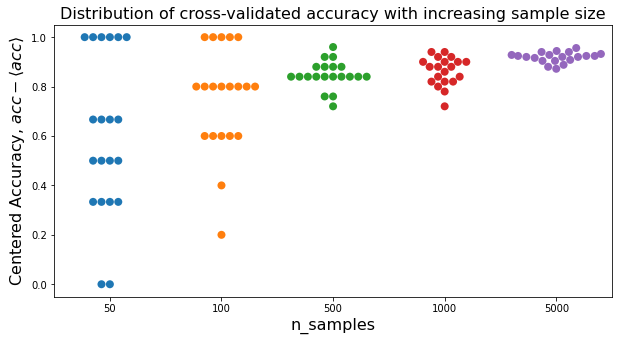

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
_ = sns.swarmplot(data=df_scores, ax=ax, size=8)
_ = ax.set_xlabel("n_samples", fontsize=16)
_ = ax.set_ylabel(r"Centered Accuracy, $acc - \langle acc \rangle$", fontsize=16)
_ = ax.set_title("Distribution of cross-validated accuracy with increasing sample size", fontsize=16)

In [18]:
# We start by loading data using nilearn dataset fetcher
# by default 2nd subject data will be fetched
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print('First subject anatomical nifti image (3D) located is at: %s' %
      haxby_dataset.anat[0])
print('First subject functional nifti image (4D) is located at: %s' %
      haxby_dataset.func[0])

# load labels
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
stimuli = labels['labels']

# identify resting state (baseline) labels in order to be able to remove them
resting_state = (stimuli == 'rest')

# extract the indices of the images corresponding to some condition or task
task_mask = np.logical_not(resting_state)

# find names of remaining active labels
categories = stimuli[task_mask].unique()

# extract tags indicating to which acquisition run a tag belongs
session_labels = labels['chunks'][task_mask]


# Load the fMRI data
# For decoding, standardizing is often very important
mask_filename = haxby_dataset.mask_vt[0]
func_filename = haxby_dataset.func[0]

# Because the data is in one single large 4D image, we need to use
# index_img to do the split easily.
fmri_niimgs = index_img(func_filename, task_mask)
classification_target = stimuli[task_mask]


Dataset created in /Users/jacobderosa/nilearn_data/haxby2001



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


Downloaded 283066368 of 291168628 bytes (97.2%,    0.3s remaining) ...done. (12 seconds, 0 min)
Extracting data from /Users/jacobderosa/nilearn_data/haxby2001/def37a305edfda829916fa14c9ea08f8/subj2-2010.01.14.tar.gz..... done.


First subject anatomical nifti image (3D) located is at: /Users/jacobderosa/nilearn_data/haxby2001/subj2/anat.nii.gz
First subject functional nifti image (4D) is located at: /Users/jacobderosa/nilearn_data/haxby2001/subj2/bold.nii.gz


In [19]:
# Then we define the various classifiers that we use
classifiers = ['svc_l2', 'svc_l1', 'logistic_l1',
               'logistic_l2', 'ridge_classifier']

# Here we compute prediction scores and run time for all these
# classifiers
cv = LeaveOneGroupOut()
classifiers_data = {}

for classifier_name in sorted(classifiers):
    classifiers_data[classifier_name] = {}
    print(70 * '_')

    # The decoder has as default score the `roc_auc`
    decoder = Decoder(estimator=classifier_name, mask=mask_filename,
                      standardize=True, cv=cv)
    t0 = time.time()
    decoder.fit(fmri_niimgs, classification_target, groups=session_labels)

    classifiers_data[classifier_name] = {}
    classifiers_data[classifier_name]['score'] = decoder.cv_scores_
    classifiers_data[classifier_name]['map'] = decoder.coef_img_['house']

    print("%10s: %.2fs" % (classifier_name, time.time() - t0))
    for category in categories:
        print("    %14s vs all -- AUC: %1.2f +- %1.2f" % (
            category,
            np.mean(classifiers_data[classifier_name]['score'][category]),
            np.std(classifiers_data[classifier_name]['score'][category]))
        )

    # Adding the average performance per estimator
    scores = classifiers_data[classifier_name]['score']
    scores['AVERAGE'] = np.mean(list(scores.values()), axis=0)
    classifiers_data[classifier_name]['score'] = scores

______________________________________________________________________
logistic_l1: 17.93s
          scissors vs all -- AUC: 0.92 +- 0.05
              face vs all -- AUC: 0.98 +- 0.02
               cat vs all -- AUC: 0.96 +- 0.04
              shoe vs all -- AUC: 0.92 +- 0.08
             house vs all -- AUC: 1.00 +- 0.00
      scrambledpix vs all -- AUC: 0.99 +- 0.01
            bottle vs all -- AUC: 0.90 +- 0.08
             chair vs all -- AUC: 0.91 +- 0.06
______________________________________________________________________
logistic_l2: 62.89s
          scissors vs all -- AUC: 0.91 +- 0.08
              face vs all -- AUC: 0.97 +- 0.04
               cat vs all -- AUC: 0.97 +- 0.03
              shoe vs all -- AUC: 0.92 +- 0.09
             house vs all -- AUC: 1.00 +- 0.00
      scrambledpix vs all -- AUC: 0.96 +- 0.11
            bottle vs all -- AUC: 0.82 +- 0.18
             chair vs all -- AUC: 0.89 +- 0.18
__________________________________________________________________

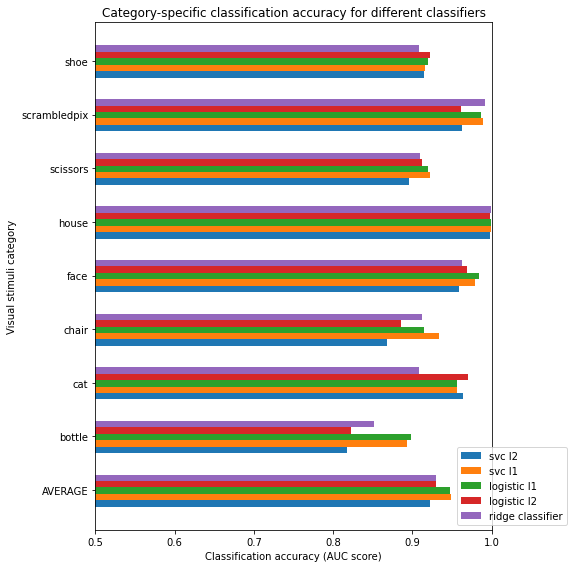

In [20]:
plt.figure(figsize=(8, 8))

all_categories = np.sort(np.hstack([categories, 'AVERAGE']))
tick_position = np.arange(len(all_categories))
plt.yticks(tick_position + 0.25, all_categories)
height = 0.12

cmap = plt.get_cmap("tab10").colors
for i, (color, classifier_name) in enumerate(zip(cmap ,classifiers)):
    score_means = [
        np.mean(classifiers_data[classifier_name]['score'][category])
        for category in all_categories
    ]

    plt.barh(tick_position, score_means,
             label=classifier_name.replace('_', ' '),
             height=height, color=color)
    tick_position = tick_position + height

plt.xlabel('Classification accuracy (AUC score)')
plt.ylabel('Visual stimuli category')
plt.xlim(xmin=0.5, xmax=1.0)
plt.legend(loc='lower left', ncol=1, bbox_to_anchor=(0.9, 0.0))
plt.title(
    'Category-specific classification accuracy for different classifiers')
plt.tight_layout()

In [21]:
# Create the dataset
rng = np.random.RandomState(1)
X = np.linspace(0, 6, 150)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.25, X.shape[0])

# Fit regression models
regr_1 = DecisionTreeRegressor(max_depth=4)
regr_2 = DecisionTreeRegressor(max_depth=15)
regr_3 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=rng)

regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)
y_3 = regr_3.predict(X)

In [22]:
cv = RepeatedKFold(n_splits=10, n_repeats=10)
cv_scores_1 = cross_validate(regr_1, X, y, cv=cv, return_train_score=True)
cv_scores_2 = cross_validate(regr_2, X, y, cv=cv, return_train_score=True)
cv_scores_3 = cross_validate(regr_3, X, y, cv=cv, return_train_score=True)

In [23]:
df_train_scores = pd.DataFrame({
    "Simple Tree": cv_scores_1["train_score"],
    "Complex Tree": cv_scores_2["train_score"],
    "Ensemble": cv_scores_3["train_score"],
}).melt(var_name="model")
df_test_scores = pd.DataFrame({
    "Simple Tree": cv_scores_1["test_score"],
    "Complex Tree": cv_scores_2["test_score"],
    "Ensemble": cv_scores_3["test_score"],
}).melt(var_name="model")

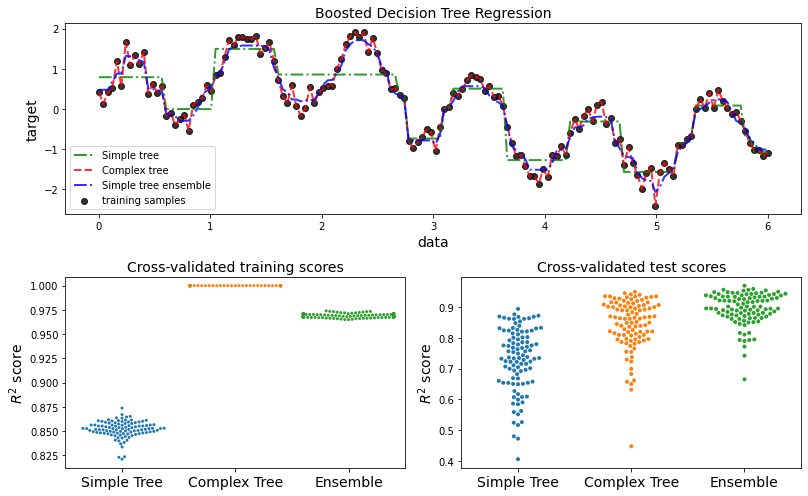

In [24]:
fig_height = 7
fig_width = golden_ratio * fig_height
fontsize=14
fig = plt.figure(tight_layout=True, figsize=(fig_width, fig_height))
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

_ = sns.swarmplot(data=df_train_scores, x="model", y="value", size=3, ax=ax1)
_ = sns.swarmplot(data=df_test_scores, x="model", y="value", size=4, ax=ax2)

_ = ax1.set_title("Cross-validated training scores", fontsize=fontsize)
_ = ax2.set_title("Cross-validated test scores", fontsize=fontsize)

for ax in [ax1, ax2]:
    ax.set_ylabel(r"$R^2$ score", fontsize=fontsize)
    ax.set_xlabel("")
    ax.tick_params(axis="x", which="major", labelsize=fontsize)

# Plot the results
ax0.scatter(X, y, c="k", alpha=0.8, label="training samples")
ax0.plot(X, y_1, c="g", ls="-.", alpha=0.8, label="Simple tree", linewidth=2)
ax0.plot(X, y_2, c="r", ls="--", alpha=0.8, label="Complex tree", linewidth=2)
ax0.plot(X, y_3, c="b", ls="-.", alpha=0.8, label="Simple tree ensemble", linewidth=2)
ax0.set_xlabel("data", fontsize=fontsize)
ax0.set_ylabel("target", fontsize=fontsize)
ax0.set_title("Boosted Decision Tree Regression", fontsize=fontsize)
_ = ax0.legend()